In [1]:
from roofline_utils import *

import time

Max SP TFLOP/s with FMA 25.068
Max DP TFLOP/s with FMA 0.392
Max SP TFLOP/s w/out FMA 12.534
Max DP TFLOP/s w/out FMA 0.196
Max TINTOP/s 12.534
SP Balance Point is at: 32.97 flop/byte
DP Balance Point is at: 0.52 flop/byte
INT Balance Point is at: 16.49 intop/byte

These values get passed as LLM context so the model can infer about rooflines:
Peak SP GFLOP/s 25067.52 with FMA
Peak DP GFLOP/s 391.68 with FMA
Peak GINTOP/s 12533.76 with FMA


In [2]:
# please create a file called '.llm-api-key' with your api key and no newline characters
with open('./.llm-api-key', 'r') as file:
    LLM_API_KEY=file.read().strip()

with open('./.openrouter-api-key', 'r') as file:
    OPENROUTER_API_KEY=file.read().strip()

### Open the Trin/Val Data CSV Files

In [3]:

dtypes['language'] = 'string'
dtypes['numTokens'] = np.int64
dtypes['kernelCode'] = 'string'
dtypes['isBB'] = np.int64
dtypes['class'] = 'string'
dtypes['answer'] = 'string'


# we need to gather more data for this dataset
trainDF = pd.read_csv('train-dataset-balanced-CUDA-only.csv', quotechar='"', dtype=dtypes)
valDF = pd.read_csv('validation-dataset-balanced-CUDA-only.csv', quotechar='"', dtype=dtypes)

trainDF['isTrain'] = 1
valDF['isTrain'] = 0

df = pd.concat([trainDF, valDF], ignore_index=True)


In [4]:
print(df.shape)
print(df.columns)
print(df.dtypes)
print(df.head())
print(df.tail())

(170, 23)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer', 'isTrain'],
      dtype='object')
Kernel Name    string[python]
traffic               float64
dpAI                  float64
spAI                  float64
dpPerf                float64
spPerf                float64
xtime                 float64
Block Size     string[python]
Grid Size      string[python]
device         string[python]
intops                float64
intPerf               float64
intAI                 float64
targetName     string[python]
exeArgs        string[python]
kernelName     string[python]
language       string[python]
numTokens               int64
kernelCode     string[python]
isBB                    int64
class          string[python]
answer         string[python]
isTrain                 i

### Check some high-level stats

In [5]:
# how many different kernel invocations did we capture?

totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 158
Total unique kernel executions recorded: 170
Number of kernels with no arithmetic intensity (AI) 60 (35.29%)
Number of non-zero AI single-precision kernels recorded: 102 (60.0%)
Number of non-zero AI double-precision kernels recorded: 27 (15.88%)
Number of non-zero Perf single-precision kernels recorded: 102 (60.0%)
Number of non-zero Perf double-precision kernels recorded: 27 (15.88%)
Number of non-zero Perf intop kernels recorded: 170 (100.0%)
Number of non-zero AI intop kernels recorded: 170 (100.0%)


### Let's plot what we have so far

We have double and single precision FLOP data, so we're going to have two plots.

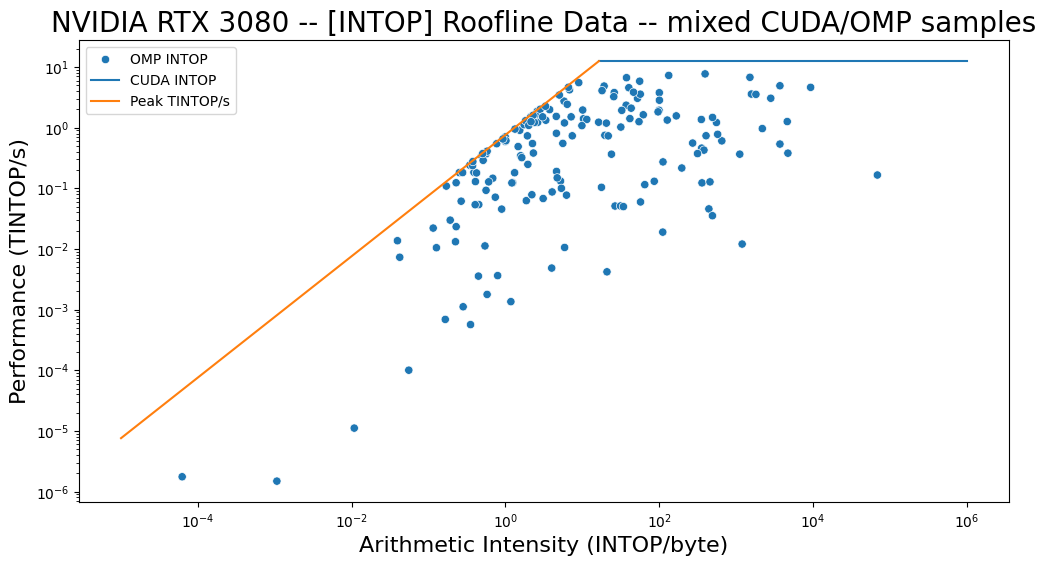

In [6]:
# it should be noted that samples with AI=0 and Perf=0 will not show on this plot

# Interesting question: why does the INTOP data fit the same FLOP roofline??
# are the ALUs for FLOP and INTOP tightly-coupled?

fig, ax = plt.subplots(1, figsize=(12,6))

sns.scatterplot(df, x='intAI', y='intPerf', hue='language', ax=ax)
#sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax)

# plot the intOPS roofline line
ax.plot([intOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e6], [intOPMaxPerfTFLOP,intOPMaxPerfTFLOP], label='Peak SP TFLOP/s')

# plot the roofline slanted line
ax.plot([1e-5, intOPMaxPerfTFLOP/maxBandwidthTBPerSec], [maxBandwidthTBPerSec*1e-5,intOPMaxPerfTFLOP], label='Max Bandwidth')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title(f'{gpuName} -- [INTOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (INTOP/byte)', fontsize=16)
ax.set_ylabel('Performance (TINTOP/s)', fontsize=16)

legend = ax.legend()
legend.labels = ['OMP INTOP', 'CUDA INTOP', 'Peak TINTOP/s', 'Bandwidth Limit']
ax.legend(legend.legend_handles, legend.labels)

plt.show()

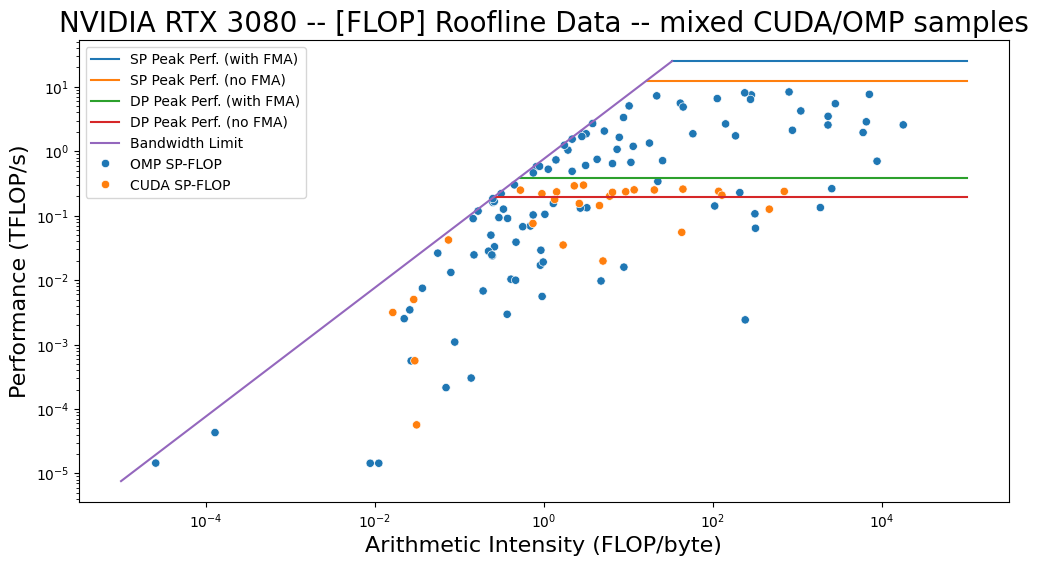

In [7]:
# it should be noted that samples with dpAI=0 and dpPerf=0 will not show on this plot
fig, ax = plt.subplots(1, figsize=(12,6))



# plot the SPOPS roofline line
ax.plot([spOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e5], [spOPMaxPerfTFLOP,spOPMaxPerfTFLOP], label='Peak SP TFLOP/s (with FMA)')

ax.plot([spOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [spOPMaxPerfTFLOP/2,spOPMaxPerfTFLOP/2], label='Peak SP TFLOP/s (no FMA)')

# plot the DPOPS roofline line
ax.plot([dpOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e5], [dpOPMaxPerfTFLOP,dpOPMaxPerfTFLOP], label='Peak DP TFLOP/s (with FMA)')

ax.plot([dpOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [dpOPMaxPerfTFLOP/2,dpOPMaxPerfTFLOP/2], label='Peak DP TFLOP/s (no FMA)')

# plot the roofline slanted line
ax.plot([1e-5, spOPMaxPerfTFLOP/maxBandwidthTBPerSec], [maxBandwidthTBPerSec*1e-5,spOPMaxPerfTFLOP], label='Max Bandwidth')

sns.scatterplot(df, x='spAI', y='spPerf', ax=ax, style='language')
sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax, style='language')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.axvline(0.51)
#ax.axvline(32.94)

ax.set_title(f'{gpuName} -- [FLOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (FLOP/byte)', fontsize=16)
ax.set_ylabel('Performance (TFLOP/s)', fontsize=16)

legend = ax.legend()
legend.labels = [ 'SP Peak Perf. (with FMA)', 'SP Peak Perf. (no FMA)', 'DP Peak Perf. (with FMA)', 'DP Peak Perf. (no FMA)', 'Bandwidth Limit', 'OMP SP-FLOP', 'CUDA SP-FLOP', 'OMP DP-FLOP', 'CUDA DP-FLOP']
ax.legend(legend.legend_handles, legend.labels)

plt.show()

### Check the distribution of arithmetic intensity

### Let's add a column as a bandwidth-bound indicator

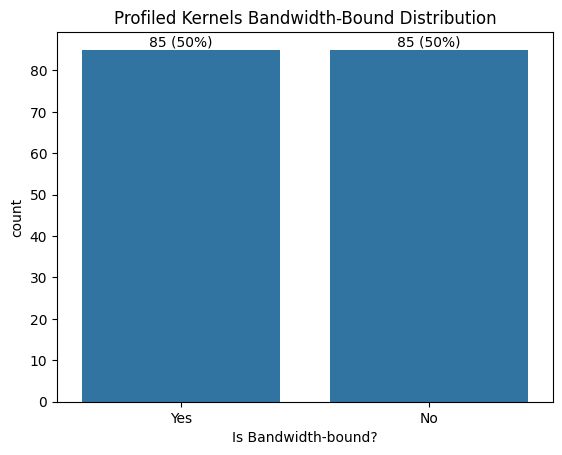

In [8]:
# let's plot the distribution

ax = sns.countplot(data=df, order=df['isBB'].value_counts(ascending=False).index, x='isBB')

abs_values = df['isBB'].value_counts(ascending=False)
rel_values = df['isBB'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_xlabel('Is Bandwidth-bound?')
ax.set_title('Profiled Kernels Bandwidth-Bound Distribution')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Yes', 'No'])

plt.show()

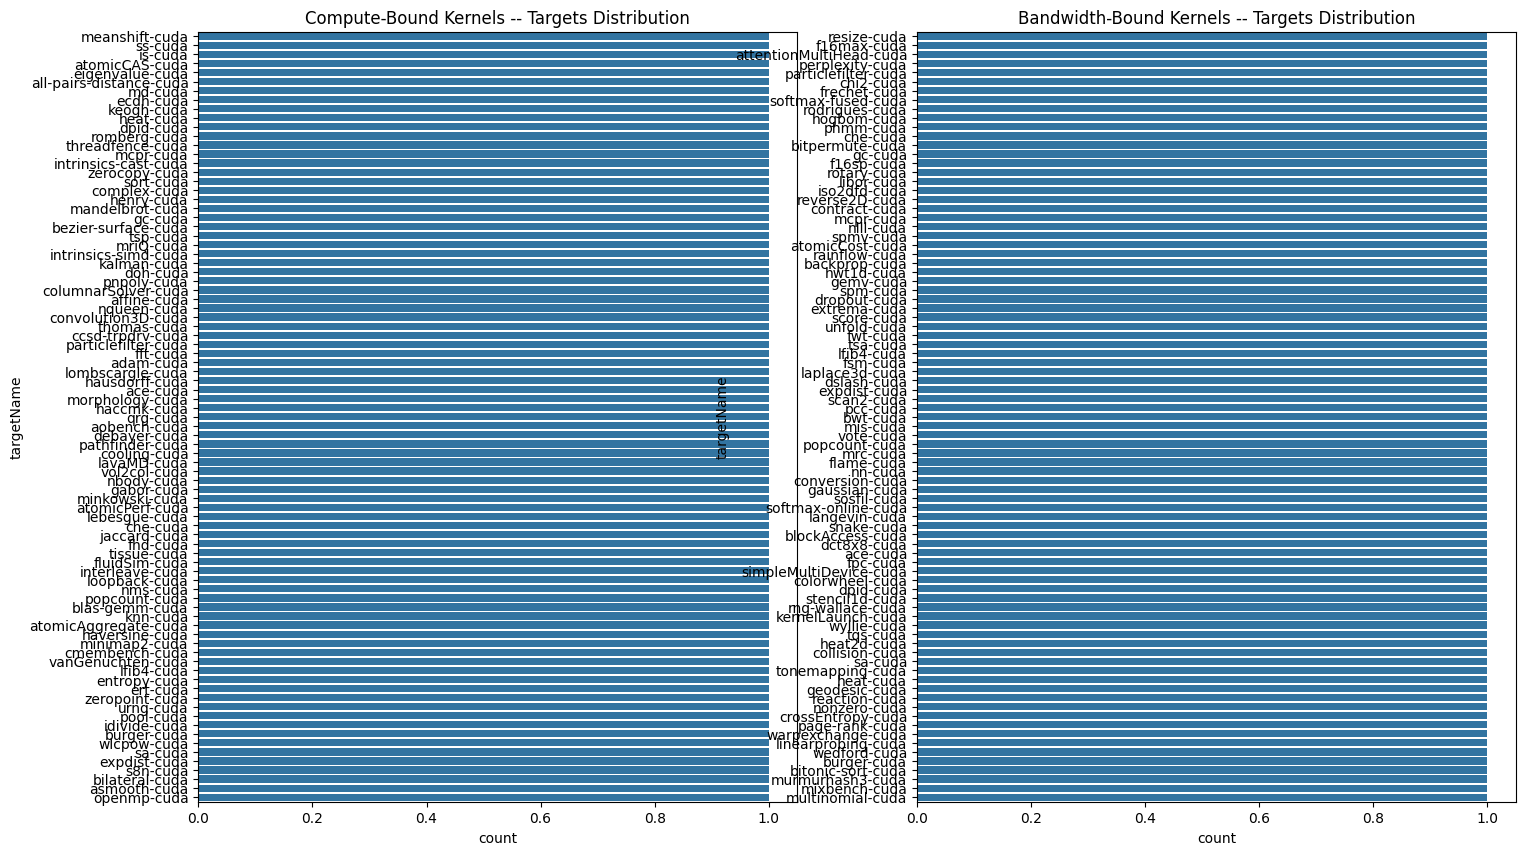

In [9]:
# now let's check how many kernels that are NOT BB come from the same program

cbKernels = df[df['isBB'] == 0].copy()
bbKernels = df[df['isBB'] == 1].copy()

fig, axs = plt.subplots(1, 2, figsize=(17, 10))

sns.countplot(data=cbKernels, order=cbKernels['targetName'].value_counts(ascending=True).index, y='targetName', ax = axs[0])
sns.countplot(data=bbKernels, order=bbKernels['targetName'].value_counts(ascending=True).index, y='targetName', ax = axs[1])

axs[0].set_title('Compute-Bound Kernels -- Targets Distribution')
axs[1].set_title('Bandwidth-Bound Kernels -- Targets Distribution')

plt.show()

### Visualize the token count distribution

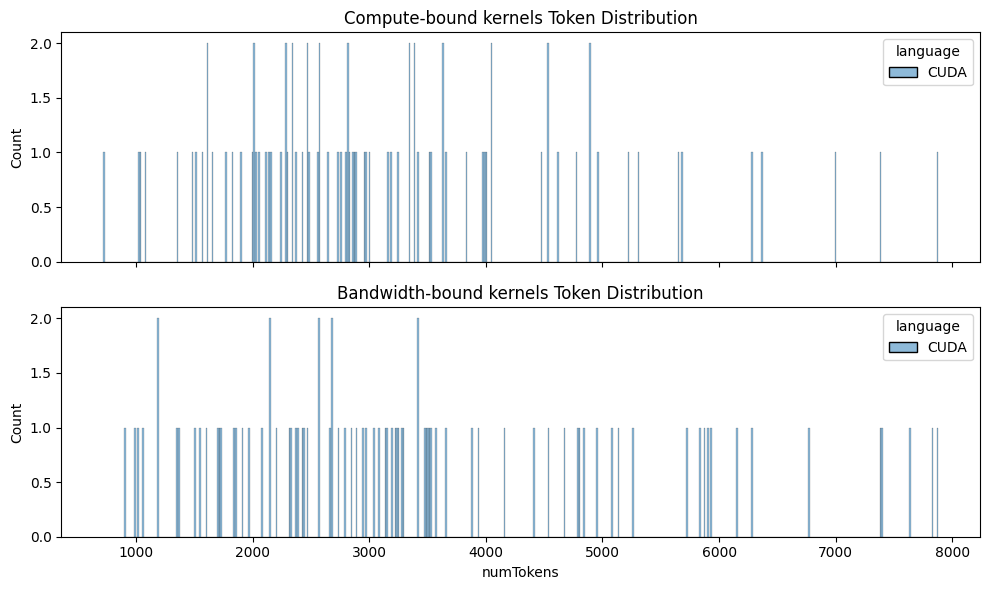

In [10]:

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Compute-bound kernels Token Distribution
sns.histplot(data=df[df['isBB'] == 0], x="numTokens", hue="language", kde=False, bins=500, ax=axes[0])
axes[0].set_title('Compute-bound kernels Token Distribution')

# Bandwidth-bound kernels Token Distribution
sns.histplot(data=df[df['isBB'] == 1], x="numTokens", hue="language", kde=False, bins=500, ax=axes[1])
axes[1].set_title('Bandwidth-bound kernels Token Distribution')

# Adjust layout
plt.tight_layout()
plt.show()

# Run Trials

In [11]:

async def ask_llm_for_roofline_classification(chatHistory, useAzure=False, temp=1.0, topp=0.1, timeout=60):

    model_client = None
    if useAzure:
        # https://finetuning-gpt-stanford.openai.azure.com/openai/deployments/gpt-4o-mini-2024-07-18-RooflineSecondEpoch/chat/completions?api-version=2024-10-21
        # https://finetuning-gpt-stanford.openai.azure.com/openai/deployments/gpt-4o-mini-2024-07-18-roofbal/chat/completions?api-version=2024-10-21
        # https://finetuning-gpt-stanford.openai.azure.com/openai/deployments/gpt-4o-mini-2024-07-18-roofbal-2/chat/completions?api-version=2024-10-21
        # https://finetuning-gpt-stanford.openai.azure.com/openai/deployments/gpt-4o-mini-2024-07-18-cudaroof/chat/completions?api-version=2024-10-21
        model_client = AzureOpenAIChatCompletionClient(
                model='gpt-4o-mini',
                azure_endpoint='https://finetuning-gpt-stanford.openai.azure.com',
                #azure_endpoint='https://galor-m6d0ej1n-eastus2.cognitiveservices.azure.com',
                #azure_endpoint='https://galor-m6d0ej1n-eastus2.cognitiveservices.azure.com',
                #azure_deployment='gpt-4o-mini',
                #azure_deployment='gpt-4o-mini-2024-07-18-roofline_balanced',
                #azure_deployment='gpt-4o-mini-2024-07-18-RooflineSecondEpoch',
                #azure_deployment='gpt-4o-mini-2024-07-18-roofbal',
                #azure_deployment='gpt-4o-mini-2024-07-18-roofbal-2',
                azure_deployment='gpt-4o-mini-2024-07-18-cudaroof',
                api_key=LLM_API_KEY,
                timeout=timeout,
                temperature=temp,
                top_p = topp,
                api_version='2024-10-21',
                #api_version='2024-08-01-preview',
                #api_version='2025-01-01-preview',
        )
    else:
        model_client = OpenAIChatCompletionClient(
                model='openai/gpt-4o-mini',
                base_url='https://openrouter.ai/api/v1',
                api_key=OPENROUTER_API_KEY,
                timeout=timeout,
                top_p = topp,
                temperature=temp,
                model_info = {'vision':False, 'function_calling':True, 'json_output':True, 'model_family':'unknown'}
        )

    agent = AssistantAgent(
        name="assistant",
        model_client=model_client,
        model_context=chatHistory
    )

    await agent.run()
    return agent._model_context




async def run_row_trial(dfRow, temp, topp):
    #targetName = dfRow['targetName']
    kernelName = dfRow['Kernel Name']
    exeArgs = dfRow['exeArgs']
    blockSz = dfRow['Block Size']
    gridSz = dfRow['Grid Size']
    language = dfRow['language']
    device = dfRow['device']
    kernelCode = dfRow['kernelCode']

    #infoMsg = make_kernel_info_message(device, exeArgs, kernelName, blockSz, gridSz, language)

    #chatHist = await make_chat_history(infoMsg, kernelCode)
    #assert chatHist != None

    #resultHist = await ask_llm_for_roofline_classification(chatHist, useAzure=True, temp=temp, topp=topp, timeout=60)
    ##resultHist = await ask_llm_for_roofline_classification(chatHist, useAzure=False, temp=temp, topp=topp, timeout=60)
    #assert resultHist != None

    #resultMessages = await resultHist.get_messages()
    #return resultMessages

    infoMsg = make_kernel_info_message(device, exeArgs, kernelName, blockSz, gridSz, language)

    # only include OMP examples
    if language == 'OMP':
        chatHist = await make_chat_history(infoMsg, kernelCode, 2)
    # only include CUDA examples
    else:
        assert language == 'CUDA'
        chatHist = await make_chat_history(infoMsg, kernelCode, 3)

    assert chatHist != None
    resultHist = await ask_llm_for_roofline_classification(chatHist, useAzure=True, temp=temp, topp=topp, timeout=60)
    assert resultHist != None

    resultMessages = await resultHist.get_messages()
    return resultMessages

### Hyperparameters to Sweep

In [12]:
NUM_TRIALS = 3

#temps = [0.1, 0.2, 0.5]
temps = [0.1]

#topPs = [0.2, 0.5, 0.9]
topPs = [0.2]

resultsCSV = 'trainedModel-inference-BALANCED-training-results-epoch1-CUDA-only.csv'


# if we already captured some data
if os.path.isfile(resultsCSV):
    dtypes['topp'] = np.float64
    dtypes['temp'] = np.float64
    dtypes['llmResponse'] = 'string'
    dtypes['trial'] = np.int64
    dtypes['isTrain'] = np.int64

    resultsDF = pd.read_csv(resultsCSV, quotechar='\"', dtype=dtypes)
else:
    # setup the resultsDF
    resultsDF = pd.DataFrame()


def is_already_sampled(df, row, trial, temp, topp):

    targetName = row['targetName']
    kernelName = row['Kernel Name']

    if df.shape[0] == 0:
        return False

    resultRow = df[(df['temp'] == temp) & (df['topp'] == topp) & (df['trial'] == trial) & (df['Kernel Name'] == kernelName) & (df['targetName'] == targetName)]

    if resultRow.shape[0] == 0:
        return False

    assert resultRow.shape[0] == 1, f"resultRow.shape = {resultRow.shape}"

    response = resultRow.iloc[0]['llmResponse']

    return response != ''

### Collect Data

In [13]:
# calculate how many total iters

totalQueries = NUM_TRIALS * len(temps) * len(topPs) * df.shape[0]
print(totalQueries)

510


In [14]:
# add a row to the dataframe keeping track of the returned result

with tqdm(total=totalQueries) as pbar:
    for trial in range(NUM_TRIALS):
        for temp in temps:
            for topp in topPs:
                for index, row in df.iterrows():

                    targetName = row['targetName']
                    kernelName = row['Kernel Name']

                    # check if we already sampled this point
                    if is_already_sampled(resultsDF, row, trial, temp, topp):
                        #print(f'Already sampled, skipping \t{targetName}: [{kernelName}]')
                        pbar.update(1)
                        continue

                    resultMsgs = await run_row_trial(row, temp, topp)


                    # make a copy so we can modify it
                    row = row.copy().to_frame().T.reset_index(drop=True)

                    assert row.shape[0] == 1

                    row['trial'] = trial
                    row['topp'] = topp
                    row['temp'] = temp
                    row['llmResponse'] = ''

                    # get the last message (it's the answer)
                    #pprint(resultMsgs)

                    # the last message contains the LLM response
                    resultStr = resultMsgs[-1].content

                    if not (resultStr in ['Compute', 'Bandwidth']):
                        print(f'{targetName}: [{kernelName}] bad response: [{resultStr}]')

                    row['llmResponse'] = resultStr

                    resultsDF = pd.concat([resultsDF, row], ignore_index=True)

                    # spam save the CSV -- it's a small amount of data so it's not much of a time-sink
                    # it'll also help slow down quickly querying the model so we don't get cloudflare banned
                    resultsDF.to_csv(resultsCSV, quoting=csv.QUOTE_NONNUMERIC, quotechar='\"', index=False, na_rep='NULL')

                    pbar.update(1)
                    time.sleep(0.5)

  0%|          | 0/510 [00:00<?, ?it/s]/home/gbolet/miniconda3/envs/hecbench-roofline/lib/python3.11/site-packages/autogen_agentchat/agents/_assistant_agent.py:386: UserWarning: Resolved model mismatch: gpt-4o-mini-2024-07-18 != gpt-4o-mini-2024-07-18.ft-9caaa081b054449599bd04867fe0a8ae-cudaroof. Model mapping in autogen_ext.models.openai may be incorrect.
  model_result = await self._model_client.create(
  0%|          | 1/510 [00:00<05:19,  1.60it/s]/home/gbolet/miniconda3/envs/hecbench-roofline/lib/python3.11/site-packages/autogen_agentchat/agents/_assistant_agent.py:386: UserWarning: Resolved model mismatch: gpt-4o-mini-2024-07-18 != gpt-4o-mini-2024-07-18.ft-9caaa081b054449599bd04867fe0a8ae-cudaroof. Model mapping in autogen_ext.models.openai may be incorrect.
  model_result = await self._model_client.create(
  0%|          | 2/510 [00:01<07:02,  1.20it/s]/home/gbolet/miniconda3/envs/hecbench-roofline/lib/python3.11/site-packages/autogen_agentchat/agents/_assistant_agent.py:386: U